In [28]:
import numpy as np 
import pandas as pd 
import os
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import torch.optim as optim
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [27]:
imagepaths=[]
lebels=[]
for root, dirs, files in os.walk("../input/leapgestrecog/", topdown=True):
    for name in files:
        path = os.path.join(root, name)
        if path.endswith("png"):
            imagepaths.append(path)

print(len(imagepaths))

40000


In [29]:
labels=[]
for path in imagepaths:
    category=path.split("/")[-1]
    label = int(category.split("_")[2]) 
    labels.append(label)
labels=torch.tensor(labels)-1

In [30]:
#### just a function to show images
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols+1e-6)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        plt.axis('off')
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    
    plt.show()

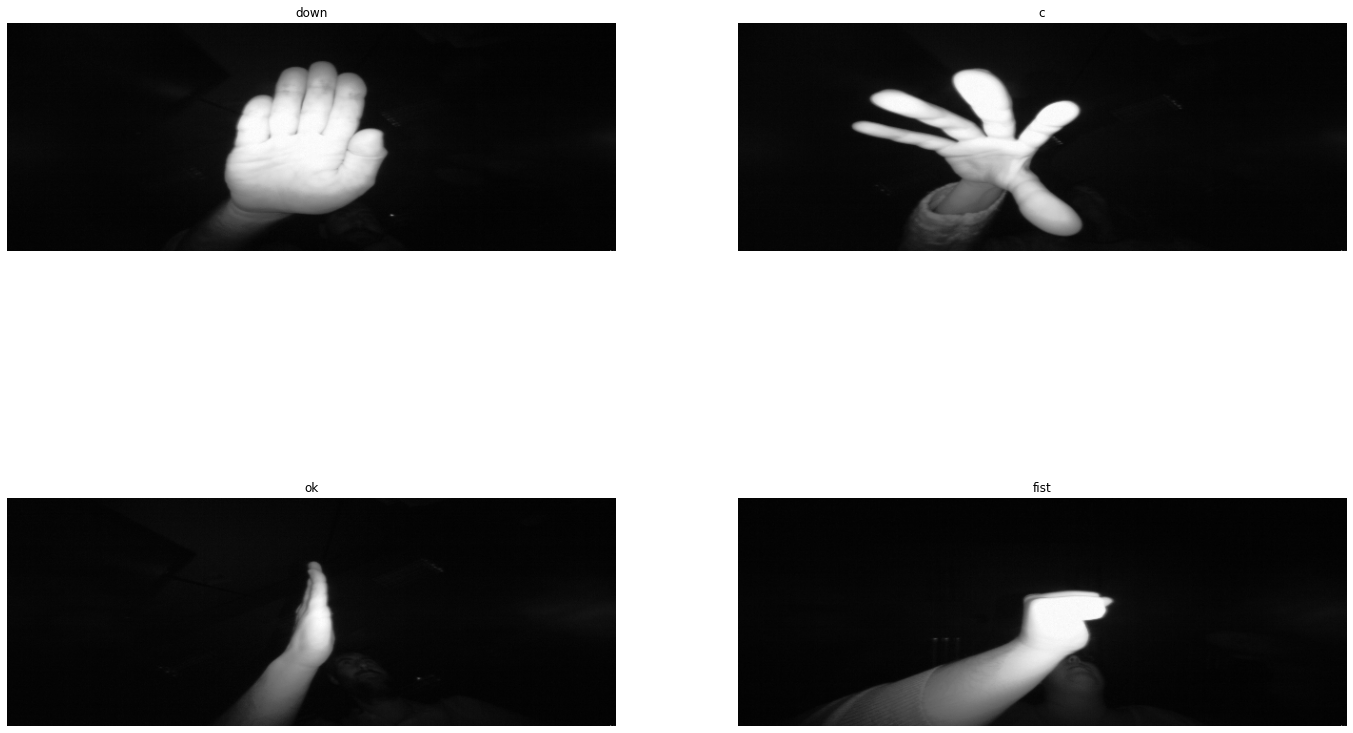

In [36]:
idxs=random.sample(range(len(imagepaths)),4)
sample_imgs=[]
titles=[]
class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"]
for idx in idxs:
    sample_imgs.append(imread(imagepaths[idx]))
    titles.append(class_names[labels[idx]])
show_images(sample_imgs,titles=titles,cols=2)

In [37]:
class dataset(object):
    def __init__(self,paths,labels,transform=None):
        self.path=paths
        self.transform=transform
        self.labels=labels
    def __len__(self):
        return len(self.path)
    def __getitem__(self,idx):
        img=imread(self.path[idx])
        img=torch.tensor(img,dtype=torch.float32).unsqueeze(0)
#         target=torch.tensor(self.labels[index])
        return img,self.labels[idx]
        

In [38]:
hands=dataset(paths=imagepaths,labels=labels)
lengths=[int(len(hands)*0.7), int(len(hands)*0.2),len(hands)-int(len(hands)*0.7)-int(len(hands)*0.2)]
train_x,val_x,test_x=torch.utils.data.dataset.random_split(hands,lengths=lengths)
train_dataloader= torch.utils.data.DataLoader(train_x, batch_size=2, shuffle=True,collate_fn=None)
val_dataloader=   torch.utils.data.DataLoader(val_x, batch_size=2, shuffle=True,collate_fn=None)
test_dataloader=  torch.utils.data.DataLoader(test_x, batch_size=2, shuffle=True,collate_fn=None)

In [41]:
class Net(nn.Module):
    def __init__(self,out_class=10,input_channels=1):
        super(Net,self).__init__()
        self.conv_layer=nn.Sequential(
                        nn.Conv2d(input_channels,64,kernel_size=5),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3),
                        nn.Conv2d(64,32,kernel_size=3),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3),
                        nn.Conv2d(32,16,kernel_size=5),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3),
                        )
        self.fc=nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(2464,1024),
                        nn.ReLU(),
                        nn.Linear(1024,128),
                        nn.ReLU(),
                        nn.Linear(128,10),
                        )
    def forward(self,x):
        x=self.conv_layer(x)
        x=self.fc(x)
        return x
    

In [42]:
model=Net()
model.cuda()
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)


### validation loss become zero after 3 epoches 
num_epochs=3
best_val_loss=9999
loss_train_history= []
loss_valid_history= []
for epoch in range(num_epochs):
    train_loss=0
    val_loss=0
    for batch,(imgs,targets) in tqdm(enumerate(train_dataloader)):
        imgs=imgs.cuda()
        targets=targets.cuda()
        
        preds=model(imgs)
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        loss=criterion(preds,targets)
        # calculate the gradients
        loss.backward()
        # update the parameters
        optimizer.step()
        
        train_loss+= loss.detach().item()
    loss_train_history.append(train_loss/(batch+1))
    model.eval()
    with torch.no_grad():
        for batch,(imgs,targets) in enumerate(val_dataloader):
            imgs=imgs.cuda()
            targets=targets.cuda()
            
            preds=model(imgs)
            
            loss=criterion(preds,targets)
            val_loss+=loss.detach().item()
        loss_valid_history.append(val_loss/(batch+1))
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.6f}  Valid Loss: {:.6f}'.format(epoch,loss_train_history[epoch], loss_valid_history[epoch]))
    print('--------------------------------------------------')
    if best_val_loss> loss_valid_history[epoch]:
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_valid_history[epoch], epoch, num_epochs))
        best_val_loss=loss_valid_history[epoch]
        
        
        

14000it [05:12, 44.85it/s]



--------------------------------------------------
Epoch: 0  Train Loss: 0.121087  Valid Loss: 0.008706
--------------------------------------------------

Minimum Validation Loss of 0.0087 at epoch 0/1


In [43]:
model.eval()
all_predictions=[]
all_targets=[]
for batch,(imgs,targets) in tqdm(enumerate(test_dataloader)):
    with torch.no_grad():
        imgs=imgs.cuda()
        targets=targets.cuda()
        preds=model(imgs)
        _,predicted=torch.max(preds,axis=1)
        all_predictions.append(predicted)
        all_targets.append(targets)
all_predictions=torch.cat(all_predictions)
all_targets=torch.cat(all_targets)
    

2000it [00:12, 160.12it/s]


In [44]:
all_targets=all_targets.cpu().data.numpy()
all_predictions=all_predictions.cpu().data.numpy()

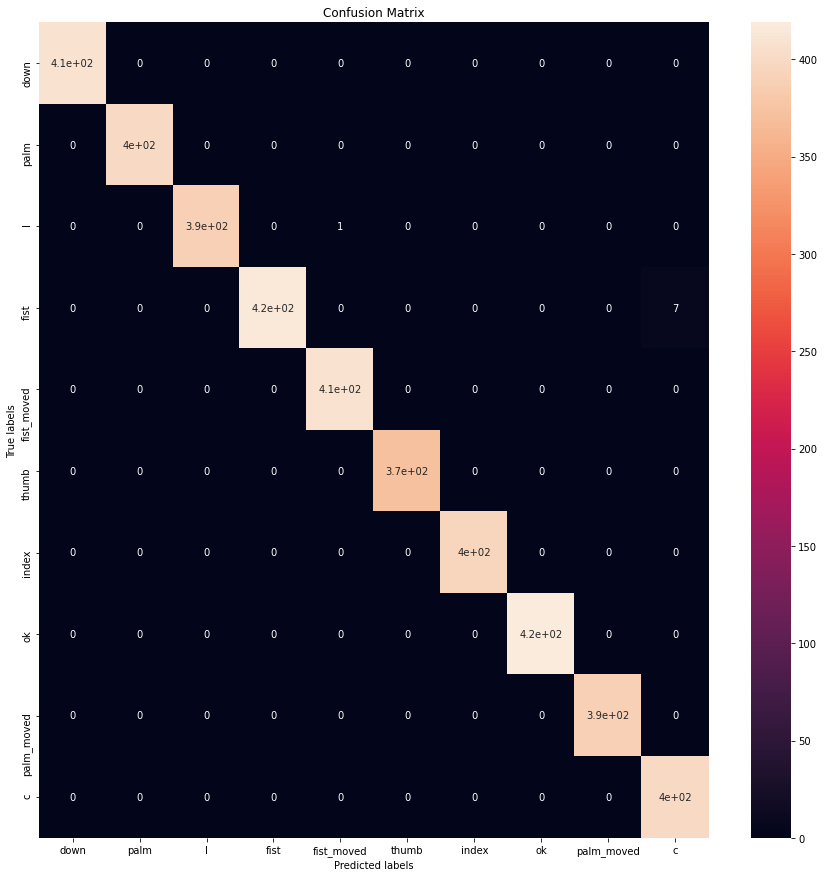

In [46]:
cm=confusion_matrix(all_targets,all_predictions)
plt.figure(figsize=(15,15))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(class_names);
ax.yaxis.set_ticklabels(class_names);